In [8]:
# pip install --user sklearn
import sys
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
#! pip install --user pandas
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer

## 1. Levantamos el dataset

In [3]:

fake = pd.read_csv("../archive/Fake.csv")
true = pd.read_csv("../archive/True.csv")

# ponemos los dos en uno
fake["label"] = 1
true["label"] = 0
df = pd.concat([fake, true], ignore_index = True)
print(df.text)

0        Donald Trump just couldn t wish all Americans ...
1        House Intelligence Committee Chairman Devin Nu...
2        On Friday, it was revealed that former Milwauk...
3        On Christmas day, Donald Trump announced that ...
4        Pope Francis used his annual Christmas Day mes...
                               ...                        
44893    BRUSSELS (Reuters) - NATO allies on Tuesday we...
44894    LONDON (Reuters) - LexisNexis, a provider of l...
44895    MINSK (Reuters) - In the shadow of disused Sov...
44896    MOSCOW (Reuters) - Vatican Secretary of State ...
44897    JAKARTA (Reuters) - Indonesia will buy 11 Sukh...
Name: text, Length: 44898, dtype: object


## 2. Preprocesamiento: limpiamos el texto

In [4]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    # agregar otras...
    return text

df.title = df.title.map(clean_text)
df.text = df.text.map(clean_text)

## 3. Vectorizamos el texto

In [5]:

# removemos palabras con muy alta o muy baja frecuencia. ademas, removemos las "stop words" del inglés
# (palabras como 'the', 'a', 'he', 'her', etc.)
MAX_FREQ_THRESHOLD = 0.1
MIN_FREQ_THRESHOLD = 0.003

# chusmear https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
cv = CountVectorizer(
    stop_words='english',
    max_df=MAX_FREQ_THRESHOLD,
    min_df=MIN_FREQ_THRESHOLD  # seguro hay mas parametros piolas para usar
)
data_cv = cv.fit_transform(df.text)
# print(cv.get_feature_names())  # vocabulario
# print(len(cv.get_feature_names())) # tamaño del vocabulario
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = df.index



## 4. Análisis exploratorio de datos

### 4.1 ¿Cuáles son las palabras más frecuentes en cada tipo de noticia?

#### Palabras más frecuentes en las noticias falsas

In [30]:
data_fake = data_dtm[:len(fake)]
data_fake = data_fake.transpose()
data_fake_top = data_fake.sum(axis=1).sort_values(ascending=False)[:60]
fake_dict = list(zip(data_fake_top.index, data_fake_top.values))
fake_dict[:10]

[('black', 7434),
 ('women', 7121),
 ('fbi', 5655),
 ('didn', 5542),
 ('story', 5518),
 ('ve', 5415),
 ('doesn', 5190),
 ('fox', 5110),
 ('actually', 4931),
 ('family', 4588)]

#### Palabras más frecuentes en las noticias verdaderas

In [31]:
data_true = data_dtm[len(fake):len(fake)+len(true)]
data_true = data_true.transpose()
data_true_top = data_true.sum(axis=1).sort_values(ascending=False)[:60]
true_dict = list(zip(data_true_top.index, data_true_top.values))
true_dict[:10]

[('north', 9842),
 ('china', 7943),
 ('tax', 7783),
 ('korea', 6842),
 ('trade', 5831),
 ('russian', 5552),
 ('countries', 5269),
 ('iran', 5189),
 ('south', 5110),
 ('nuclear', 5031)]

#### Y para visualizarlo un poco más lindo, usemos un WordCloud:

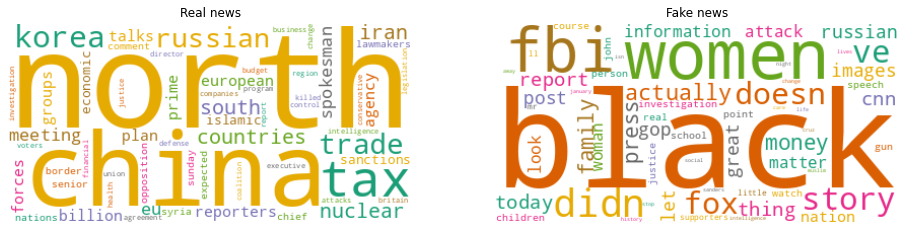

In [32]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42, collocations=False)

# Reset the output dimensions
import matplotlib.pyplot as plt

data_true_str = ''.join([(x[0] + ' ')*x[1] for x in true_dict])
data_fake_str = ''.join([(x[0] + ' ')*x[1] for x in fake_dict])
plt.rcParams['figure.figsize'] = [16, 6]
titles = ['Real news', 'Fake news']
data = [data_true_str, data_fake_str]
# Create subplots for each comedian
for index, data_str in enumerate(data):
    wc.generate(data[index])
    
    plt.subplot(1,2, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(titles[index])
    
plt.show()

- Las palabras que vemos tienen todas un buen valor semántico, indicando que el preprocesamiento del texto que hicimos es bueno. 
- Parecería que las noticias falsas tienen que ver con temas sociales
- Y que las noticias verdaderas hablan más de economía y política internacional.

### Y la parte más jugosa: técnicas de NLP para clasificar las noticias

In [6]:
Y = df['label'].to_numpy()
X = data_dtm.to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

[0 0 0 ... 0 0 0]


In [7]:
print(f"Number of training examples: {X_train.shape[0]}")
print(f"Number of testing examples: {X_test.shape[0]}")

1
Number of training examples: 31428
Number of testing examples: 13470


In [9]:
lr = LogisticRegression()
clf = svm.SVC(kernel='linear') 


In [ ]:
lr.fit(X_train,Y_train)
clf.fit(X_train, Y_train)

In [37]:
score_lr = lr.score(X_test, Y_test)
score_sv = clf.score(X_test, Y_test)
print(f"Accuracy Lr: {score_lr}")
print(f"Accuracy SV: {score_sv}")

Accuracy: 0.9726800296956198


In [38]:
"""
TODO:

- Probar con otros valores (idealmente no arbitrarios) de MIN_FREQUENCY y MAX_FREQUENCY
- Hacer grafiquitos lindos
- Probar usando solo los títulos de la noticia, ignorar el texto.
"""

'\nTODO:\n\n- Probar con otros valores (idealmente no arbitrarios) de MIN_FREQUENCY y MAX_FREQUENCY\n- Hacer grafiquitos lindos\n- Probar usando solo los títulos de la noticia, ignorar el texto.\n'